In [79]:
%load_ext autoreload
%autoreload 2

from basic_vae_module import VAE
import torch
from torch.utils.data import DataLoader

from dataset import get_dataset
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = VAE.load_from_checkpoint('vae-1.cpkt', map_location=device)

mean = [194.7155, 139.2602, 145.4779]
std = [36.0167, 38.9894, 43.4381]
def denormalize_image(image):
    image = image.cpu().detach().permute(1, 2, 0).numpy()
    image = image * std + mean
    image = image.astype(np.uint8)
    return image

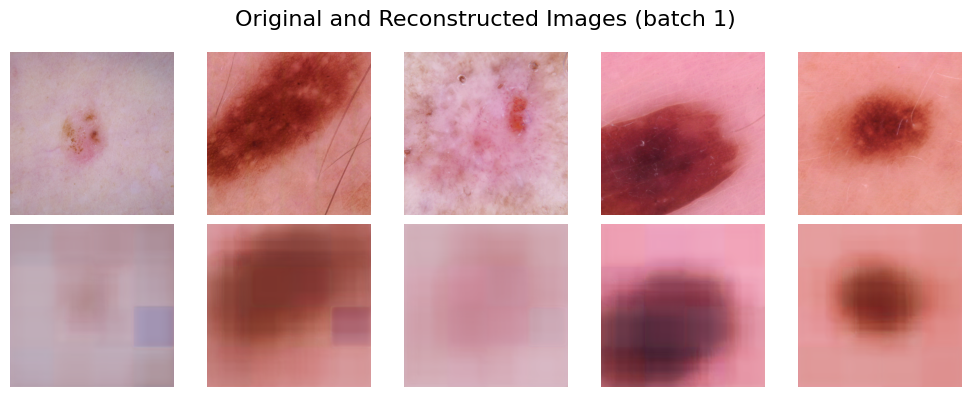

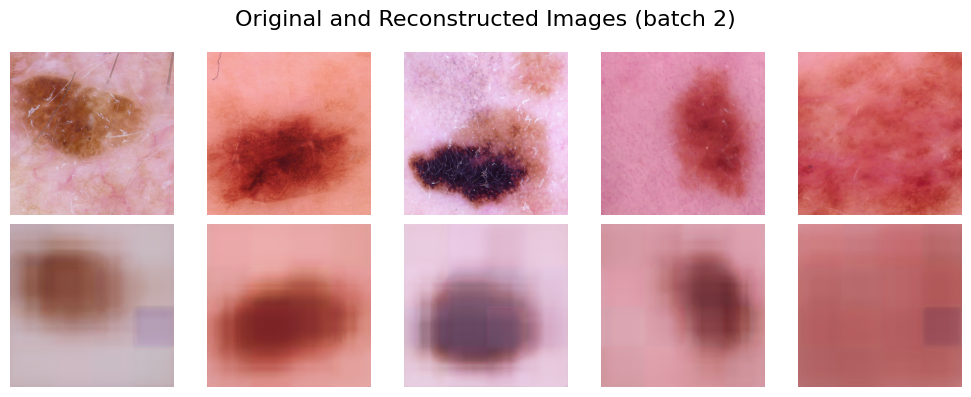

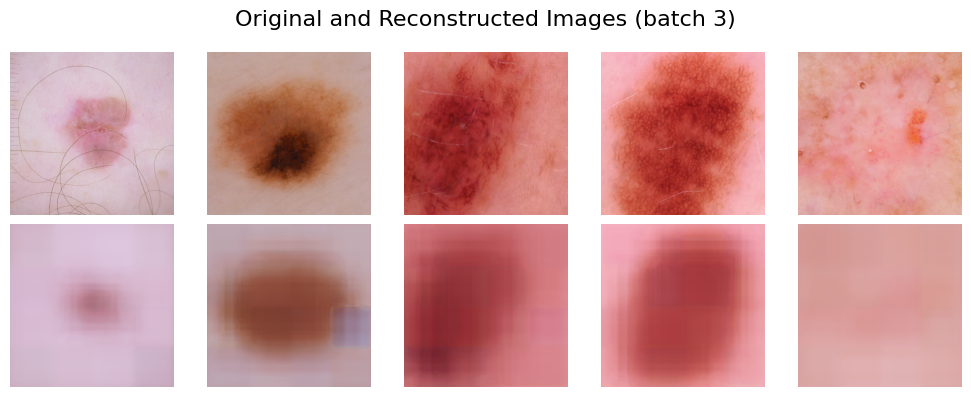

In [52]:
# Visualize some images from the validation set
val_set = get_dataset(dataset_name = "validation")

val_loader = DataLoader(val_set, batch_size=5, shuffle=False, drop_last=False, num_workers=1)

counter = 1
for batch in val_loader:
    imgs, labels = batch
    imgs = imgs.to(device)
    original_imgs = imgs
    
    recon_imgs = model.forward(imgs)
    
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    
    # add original images
    for i, ax in enumerate(axes[0]):
        image = denormalize_image(original_imgs[i])
        ax.imshow(image)
        ax.axis('off')

    # add reconstructed images
    for i, ax in enumerate(axes[1]):
        image = denormalize_image(recon_imgs[i])
        ax.imshow(image)
        ax.axis('off')
        
    plt.suptitle(f"Original and Reconstructed Images (batch {counter})", fontsize=16)
    plt.tight_layout()

    plt.show()

    counter += 1
    if counter >= 4:
        break
        


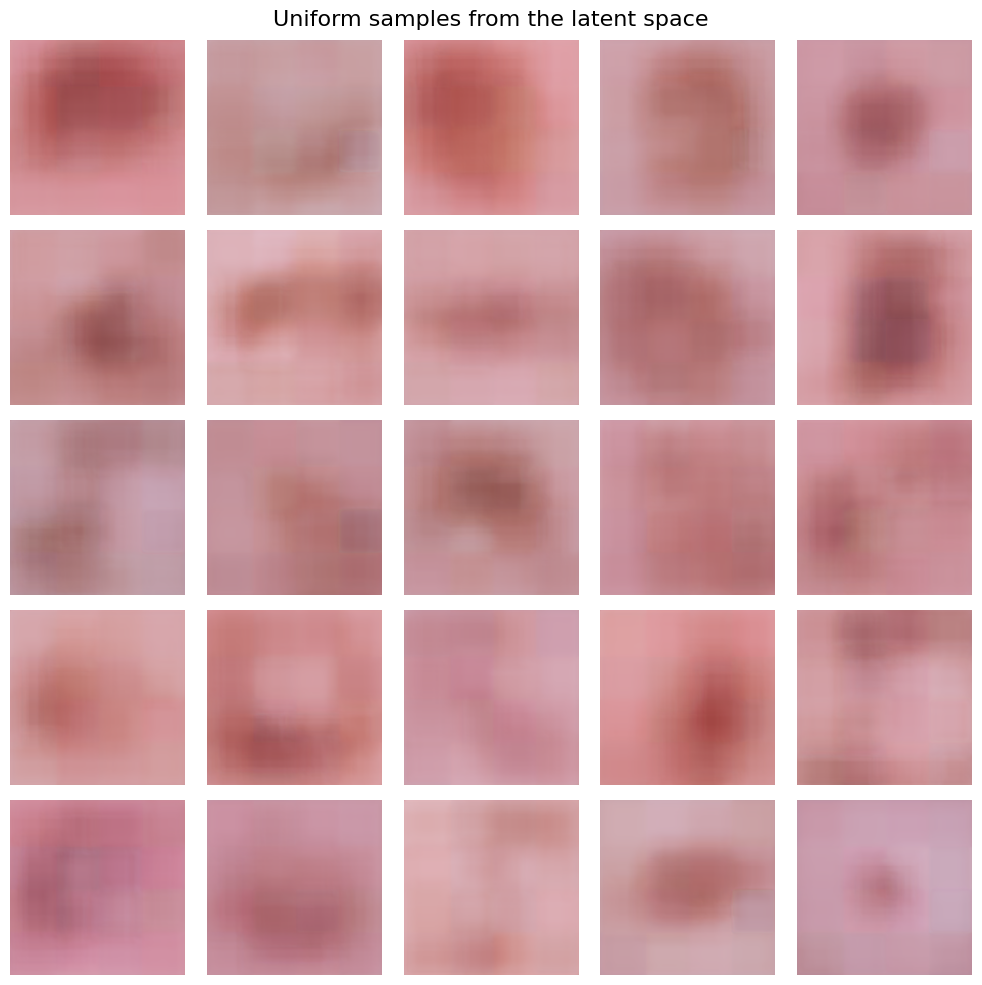

In [53]:
# Visualize random samples from the latent space

num_samples = 25

random_imgs = model.generate_samples(num_samples)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# add original images
for i, ax in enumerate(axes.flat):
    image = denormalize_image(random_imgs[i])
    ax.imshow(image)
    ax.axis('off')

plt.suptitle("Uniform samples from the latent space", fontsize=16)
plt.tight_layout()

plt.show()

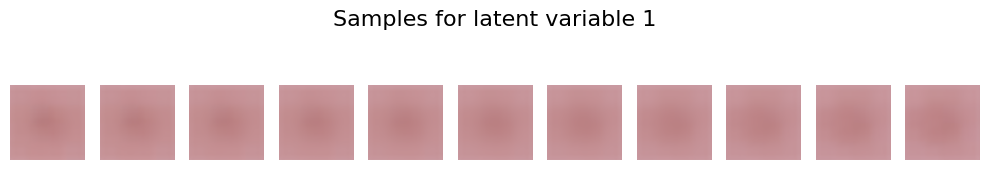

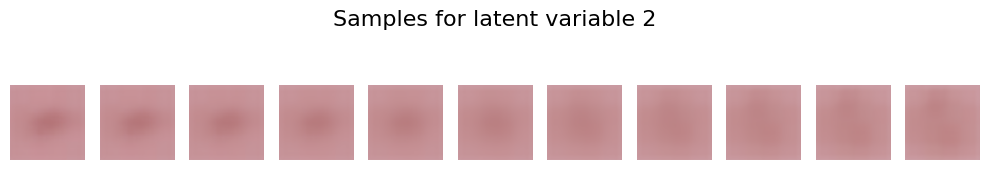

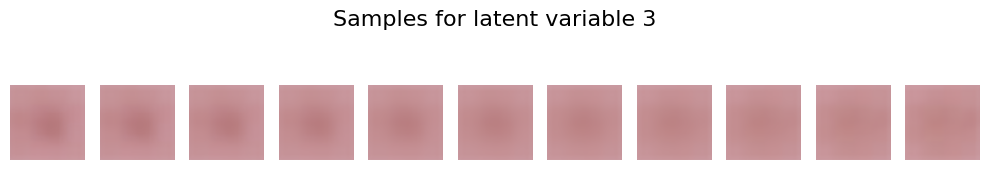

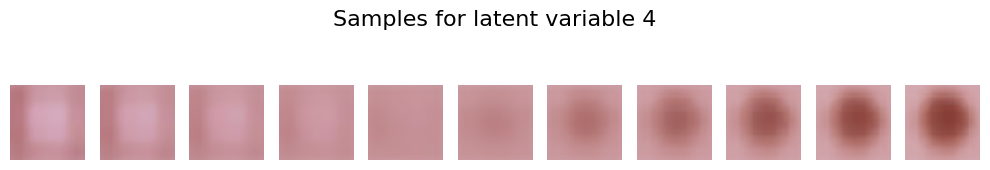

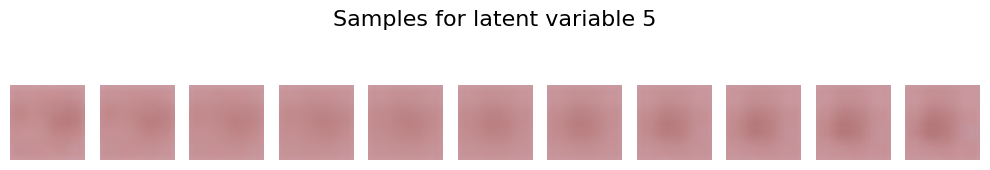

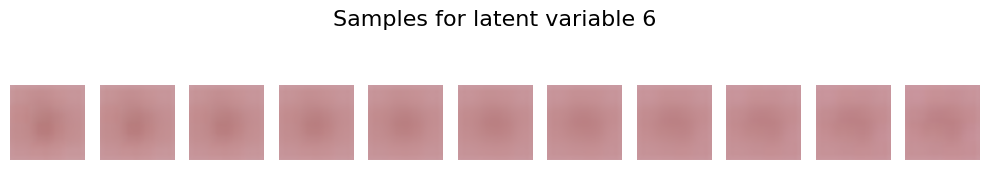

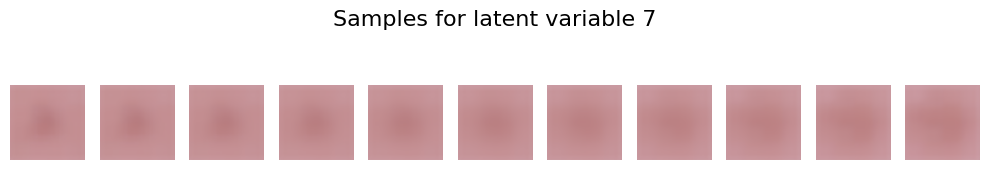

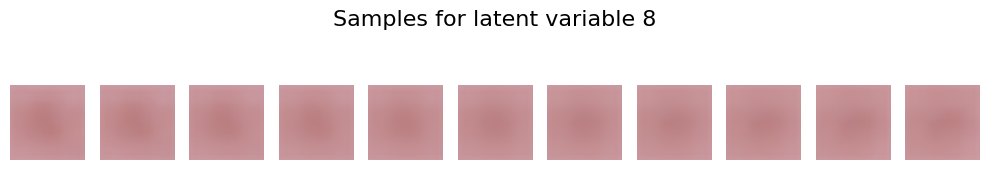

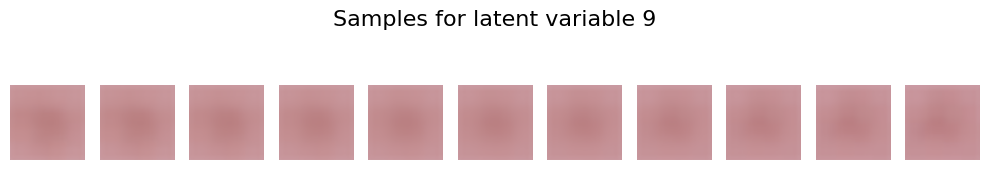

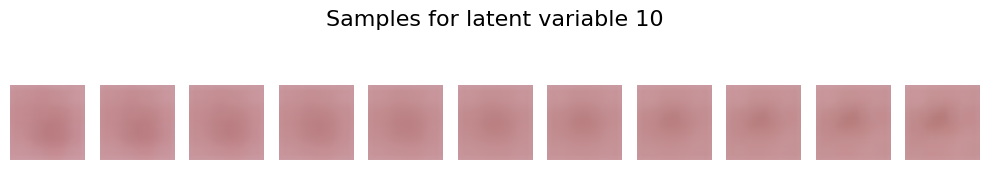

In [54]:

for i in range(10):
    
    latent_variable = i

    random_imgs = model.generate_samples_for_latent_variable(latent_variable)

    fig, axes = plt.subplots(1, 11, figsize=(10, 2))

    # add original images
    for i, ax in enumerate(axes.flat):
        image = denormalize_image(random_imgs[i])
        ax.imshow(image)
        ax.axis('off')

    plt.suptitle(f"Samples for latent variable {latent_variable + 1}", fontsize=16)
    plt.tight_layout()

    plt.show()

10
20
30


/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/matplotlib/patches.py:738: RuntimeWarning: invalid value encountered in scalar add
  x1 = self.convert_xunits(self._x0 + self._width)
/home/jschaefer/mitigating-bias-in-skin-lesion-detection-models/jsvenv/lib/python3.10/site-packages/matplotlib/transforms.py:2041: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[0, 2] += tx


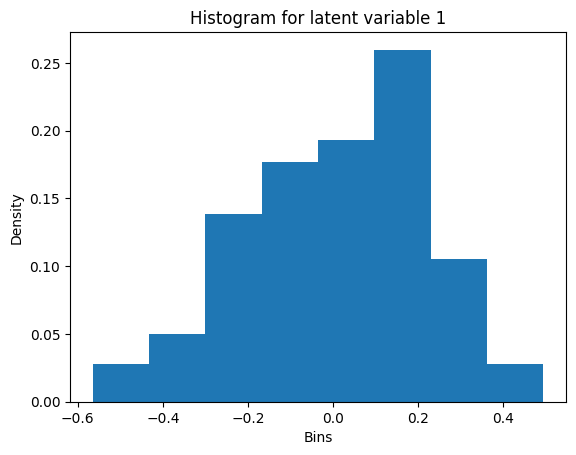

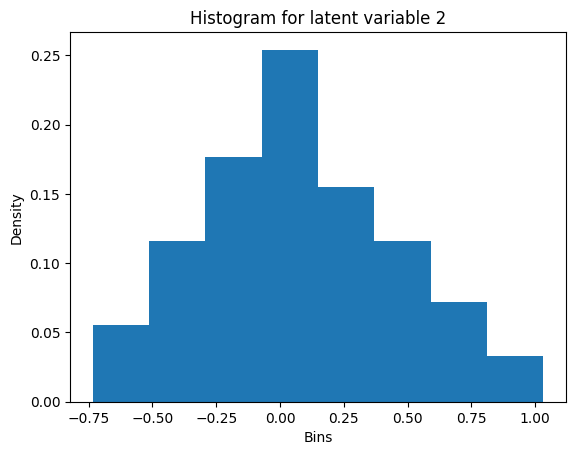

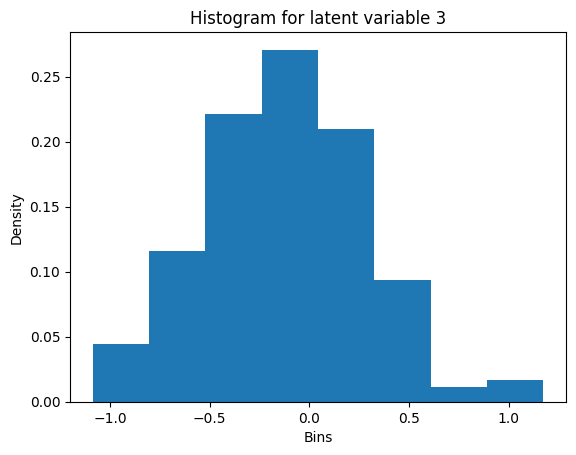

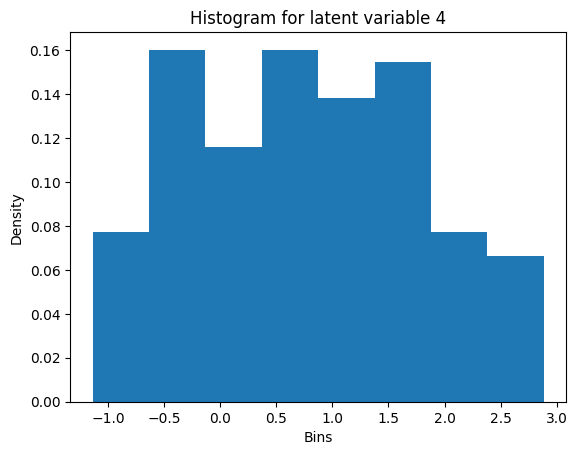

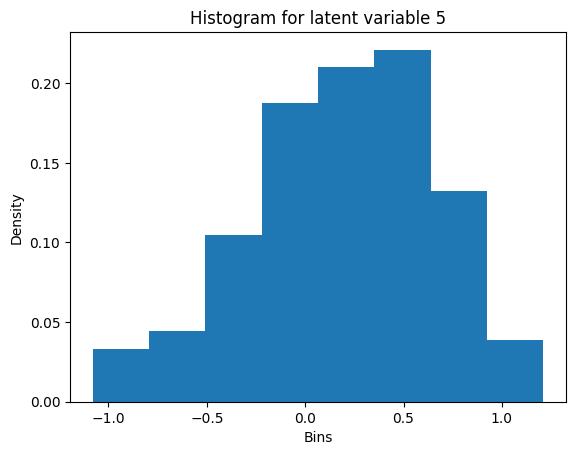

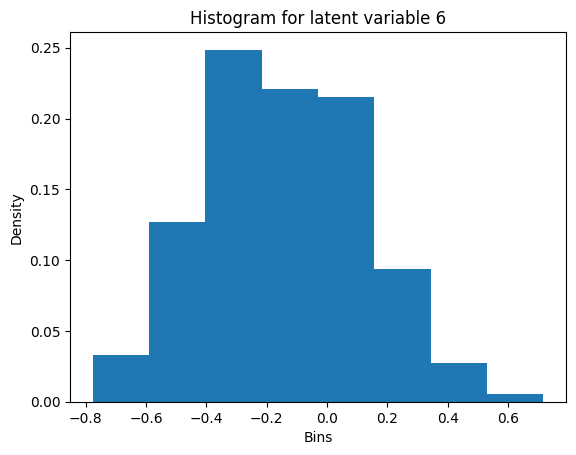

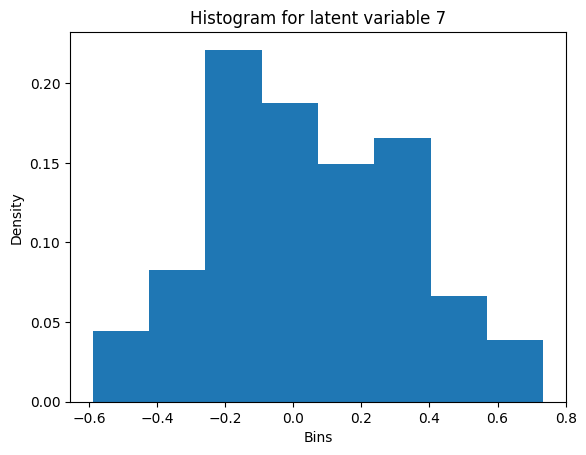

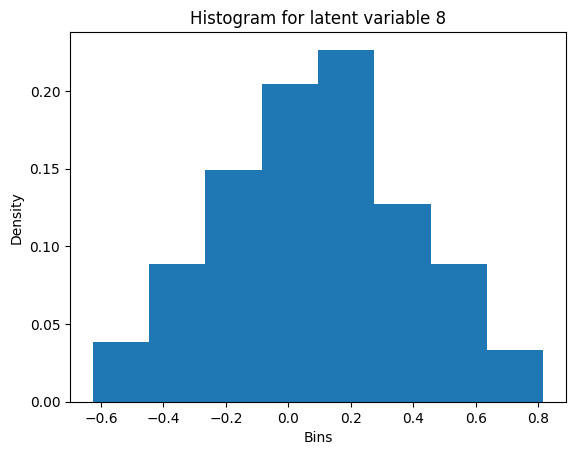

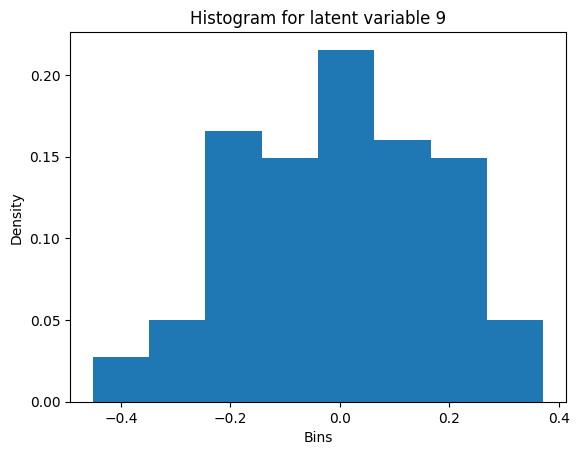

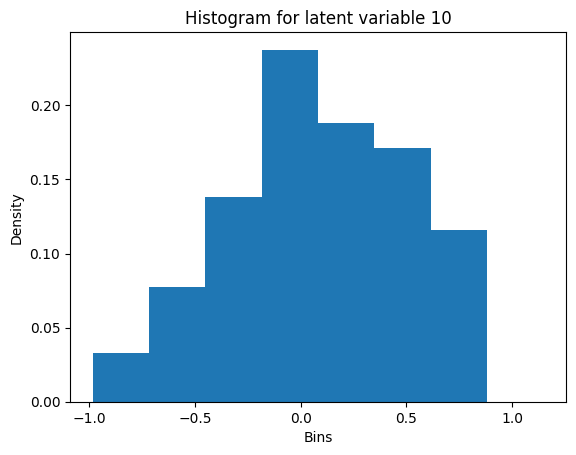

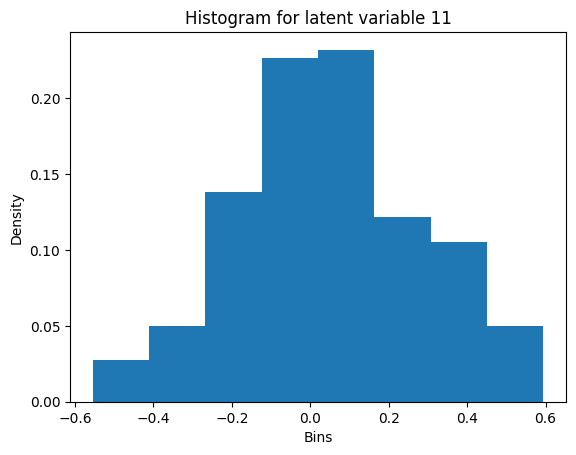

[0.00111955 0.01243941 0.00139943 0.01119547 0.00159935 0.00279887
 0.01119547 0.01119547 0.01119547 0.00373182 0.00124394 0.00559773
 0.00559774 0.01119547 0.00186591 0.00559774 0.00559774 0.00186591
 0.00373182 0.01119547 0.00373182 0.01243941 0.00223909 0.00186591
 0.00279887 0.00559774 0.01119547 0.00186591 0.00223909 0.00279887
 0.00559773 0.00559774 0.00124394 0.00559773 0.01243941 0.00111955
 0.00559774 0.00373182 0.00621971 0.01119547 0.0062197  0.01119547
 0.00186591 0.01119547 0.00101777 0.00124394 0.01119547 0.00223909
 0.00223909 0.01243941 0.00186591 0.00559773 0.00186591 0.00279887
 0.01119547 0.00373182 0.00139943 0.00124394 0.00159935 0.00279887
 0.00223909 0.00559774 0.00559774 0.01119547 0.00559773 0.00373182
 0.00559774 0.00373182 0.00559774 0.00279887 0.01119547 0.00093296
 0.00279887 0.00559773 0.00223909 0.00124394 0.00373182 0.00559773
 0.00279887 0.00310985 0.01243941 0.00186591 0.00559774 0.00159935
 0.01243941 0.00086119 0.00223909 0.00139943 0.00279887 0.0037

In [103]:


def calculate_sample_probabilities(dataset_name, visualize_latent_variables=False):
    val_set = get_dataset(dataset_name=dataset_name, id_as_label=True)

    val_loader = DataLoader(val_set, batch_size=5, shuffle=False, drop_last=False, num_workers=1)
    latent_repr_chunks = []
    all_isic_ids = []
    counter = 0
    for batch in val_loader:
        counter += 1
        if counter % 10 == 0:
            print(counter)
        imgs, labels = batch
        imgs = imgs.to(device)
        original_imgs = imgs

        chunk_latent_repr = model.encode(imgs)
        latent_repr_chunks.append(chunk_latent_repr)
        all_isic_ids.extend(labels) 

    latent_repr = torch.cat(latent_repr_chunks, dim=0)

    sample_p = np.zeros(latent_repr.shape[0])
    bins = 10

    for i in range(256):
        latent_distribution = latent_repr[:,i].cpu()
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')

        smoothing_fac = 0.0

        bin_idx = np.digitize(latent_distribution, bin_edges) 
        hist_density = hist_density / np.sum(hist_density)

        p = 1.0/(hist_density[bin_idx-1] + smoothing_fac)
        p = p/np.sum(p)

        # This is a bit different to what is described in the paper
        sample_p = np.maximum(p, sample_p)

        if i <= 10 and visualize_latent_variables:
            plt.bar(bin_edges[:-1], hist_density, width=np.diff(bin_edges), align='edge')
            plt.xlabel('Bins')
            plt.ylabel('Density')
            plt.title(f"Histogram for latent variable {i+1}")
            plt.show()


    sample_p /= np.sum(sample_p)
    print(sample_p)
    print(np.sum(sample_p))
    return sample_p, all_isic_ids

val_sample_p, val_isic_ids = calculate_sample_probabilities("validation", True)

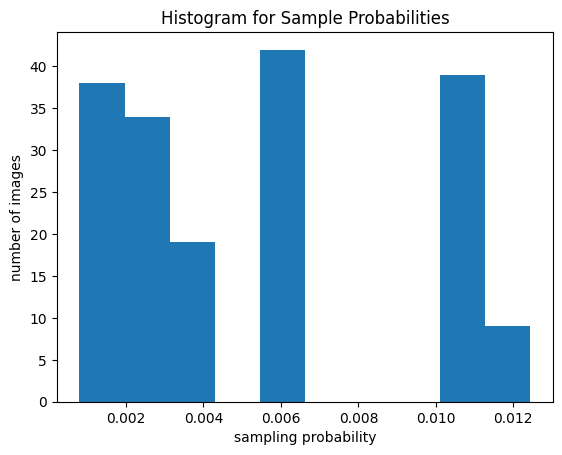

In [104]:
# Plot sample probabilities
bins=10
hist_density, bin_edges =  np.histogram(val_sample_p, density=False, bins=bins)
plt.bar(bin_edges[:-1], hist_density, width=np.diff(bin_edges), align='edge')
plt.xlabel('sampling probability')
plt.ylabel('number of images')
plt.title("Histogram for Sample Probabilities")
plt.show()

[116 144  85  71 142  44  35   0  96  32]
ISIC_0034453
ISIC_0034486
ISIC_0034417
ISIC_0034401
ISIC_0034484
ISIC_0034370
ISIC_0034361
ISIC_0034321
ISIC_0034431
ISIC_0034357


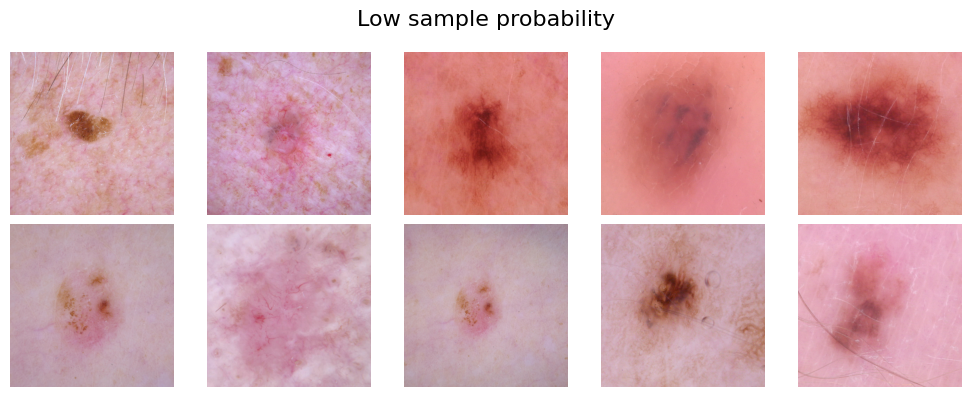

[ 54  84 101  34  49  21 147 124   1  80]
ISIC_0034381
ISIC_0034416
ISIC_0034438
ISIC_0034360
ISIC_0034376
ISIC_0034345
ISIC_0034489
ISIC_0034463
ISIC_0034322
ISIC_0034412


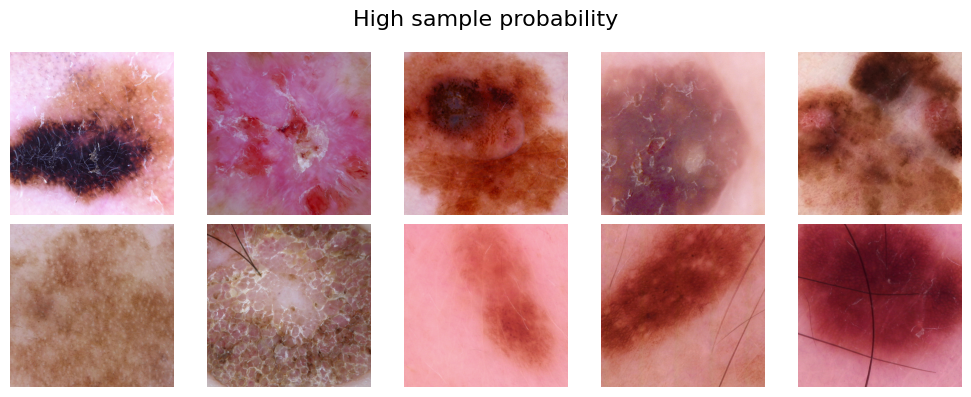

In [105]:
# Plot images with high and low sampling probability

argmins = np.argsort(val_sample_p)[:10]
print(argmins)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    isic_id = all_isic_ids[argmins[i]]
    print(isic_id)
    image = val_set.get_image_from_isic_id(isic_id)
    image = denormalize_image(image)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle(f"Low sample probability", fontsize=16)
plt.tight_layout()
plt.show()



argmaxs = np.argsort(val_sample_p)[-10:]
print(argmaxs)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    isic_id = all_isic_ids[argmaxs[i]]
    print(isic_id)
    image = val_set.get_image_from_isic_id(isic_id)
    image = denormalize_image(image)
    ax.imshow(image)
    ax.axis('off')

plt.suptitle(f"High sample probability", fontsize=16)
plt.tight_layout()
plt.show()



In [106]:
# write probabilities to csv file

data_dict = {"isic_id": all_isic_ids, "sample_probability":val_sample_p.tolist()}
dataframe = pd.DataFrame(data_dict)
dataframe.to_csv("./val_sample_probabilities.csv")

In [108]:
train_sample_p, train_isic_ids = calculate_sample_probabilities("train")

data_dict = {"isic_id": train_isic_ids, "sample_probability": train_sample_p.tolist()}
dataframe = pd.DataFrame(data_dict)
dataframe.to_csv("./train_sample_probabilities.csv")


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
[2.79478774e-05 9.18834319e-06 1.00612350e-03 ... 1.34149832e-04
 7.31726289e-05 5.74927816e-05]
0.9999999999999999


In [48]:
## Other version from UVA:

# A placeholder for the sampling probabilities for the images.
training_sample_p = np.zeros(latent_repr.shape[0])

# Consider the distribution for each latent variable.
for i in range(256):
    # Extract the latent means of the respective latent dimension.
    latent_distribution = latent_repr[:, i].cpu()

    # Generate a histogram of the latent distribution.
    hist_density, bin_edges = np.histogram(latent_distribution, density=True, bins=bins)

    # Set the boundaries of the bins to -/+ infinity.
    bin_edges[0] = -float("inf")
    bin_edges[-1] = float("inf")
    # Use the digitize function to see in which bin each sample falls.
    bin_idx = np.digitize(latent_distribution, bin_edges)

    # Convert the hist density to a probability of the respective bin.
    hist_bin_probability = hist_density / np.sum(hist_density)

    # Invert the density function to compute the sampling probability!
    sample_probabilities = 1.0 / (hist_bin_probability[bin_idx - 1] + smoothing_fac)
    # Add 1 to remove negative probabilities and use Log Sum Trick
    log_sample_probabilities = np.log(sample_probabilities + 1)

    # At the end.
    training_sample_p += log_sample_probabilities

# Overall normalization.
training_sample_p /= np.sum(training_sample_p)
print(training_sample_p)

# Plot a hist of current sample probabilities and image samples of the bins.
#self.plot_sample_prob_hist(training_sample_p.copy(), images, bins, epoch, model_name)


[0.00485929 0.00636532 0.00483343 0.00640118 0.00501024 0.00533367
 0.00602097 0.00677093 0.00642774 0.00545673 0.00463024 0.00588641
 0.00558102 0.00626514 0.00489157 0.00598945 0.00512152 0.0049672
 0.00562181 0.00598971 0.0050014  0.00584471 0.00523651 0.0047523
 0.00543931 0.00512067 0.00632108 0.00513928 0.00501191 0.004972
 0.0056783  0.00566569 0.00488806 0.00606256 0.00657142 0.00488893
 0.0055465  0.00562131 0.00572982 0.00594164 0.00532067 0.00581477
 0.00502434 0.00575225 0.00476803 0.00489611 0.00580676 0.00503388
 0.00515289 0.00667159 0.00495883 0.00541653 0.00515459 0.00533413
 0.00673699 0.00533835 0.00488214 0.00484489 0.00507454 0.00538868
 0.00499262 0.00565881 0.00625615 0.00601927 0.00601289 0.0052168
 0.00538039 0.00502225 0.0054183  0.00511194 0.0063224  0.00484261
 0.00546174 0.00530133 0.00485847 0.00476493 0.00490864 0.00537856
 0.00518581 0.00530993 0.00654738 0.00489787 0.00516295 0.00504551
 0.00649027 0.0049216  0.00518161 0.00497807 0.00514896 0.00573722
